In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os


import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False


import tensorflow as tf
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, Nadam, Adadelta, Adamax
from tensorflow.keras.layers import Dropout , BatchNormalization , Flatten , MaxPool2D,MaxPooling2D , Activation , Dense , Conv2D , InputLayer

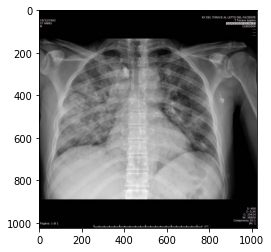

In [27]:
DATADIR_train = '/home/kartik/Desktop/coronahack-chest-xraydataset/covid_final_dataset/train'
CATEGORIES= ['COVID19', 'Normal']
 
for category in CATEGORIES:
    path = os.path.join(DATADIR_train,category)
    for img in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,img))#cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array)
        break
    break    
        

In [2]:
DATADIR_train = '/home/kartik/Desktop/coronahack-chest-xraydataset/covid_final_dataset/train'
CATEGORIES= ['COVID19', 'Normal']
 
training_data=[]
IMG_SIZE=224
def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR_train,category)
        class_num = CATEGORIES.index(category)  # giving number to each category or mapping each category to a no. 
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))#cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array , (IMG_SIZE,IMG_SIZE))
                training_data.append([new_array , class_num])
            except Exception as e:
                pass
        
        
create_training_data()  

In [3]:
import keras

Using TensorFlow backend.


In [4]:
X=[]
y=[]
for features,labels in training_data:
    X.append(features)
    y.append(labels)
    
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# Balancing

In [5]:
from sklearn.utils import class_weight
 
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights = dict(enumerate(class_weights))

In [6]:
X_test = np.array(X_test).reshape(-1,IMG_SIZE,IMG_SIZE,3)
X_train = np.array(X_train).reshape(-1,IMG_SIZE,IMG_SIZE,3)

X_train = X_train.astype("float32")/255 
X_test = X_test.astype("float32")/255

y_train = keras.utils.to_categorical(y_train , num_classes=2)
y_test = keras.utils.to_categorical(y_test , num_classes=2)

In [7]:
class_weights

{0: 13.025, 1: 0.5199600798403193}

In [12]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [45]:
cnnmodel=Sequential()

cnnmodel.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', input_shape=(224,224,3)))
cnnmodel.add(MaxPool2D(pool_size=2))
cnnmodel.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
# cnnmodel.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
cnnmodel.add(MaxPool2D(pool_size=2))
cnnmodel.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
cnnmodel.add(MaxPool2D(pool_size=2))
cnnmodel.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
# cnnmodel.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
# cnnmodel.add(BatchNormalization())
cnnmodel.add(Flatten())
cnnmodel.add(Dense(units=64, activation='relu'))
cnnmodel.add(Dense(units=2, activation='sigmoid' , activity_regularizer=l1(0.001)))

cnnmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics = METRICS)

cnnhistory= cnnmodel.fit(X_train, y_train,
              batch_size=32,
              epochs=10,
              class_weight=class_weights,
              validation_data=(X_test, y_test))

Train on 1042 samples, validate on 348 samples
Epoch 1/10
1042/1042 [==============================] - 51s 49ms/sample - loss: 0.4893 - tp: 795.0000 - fp: 368.0000 - tn: 674.0000 - fn: 247.0000 - accuracy: 0.7049 - precision: 0.6836 - recall: 0.7630 - auc: 0.8008 - val_loss: 2.5214 - val_tp: 161.0000 - val_fp: 258.0000 - val_tn: 90.0000 - val_fn: 187.0000 - val_accuracy: 0.3606 - val_precision: 0.3842 - val_recall: 0.4626 - val_auc: 0.2812
Epoch 2/10
1042/1042 [==============================] - 50s 48ms/sample - loss: 0.1891 - tp: 976.0000 - fp: 78.0000 - tn: 964.0000 - fn: 66.0000 - accuracy: 0.9309 - precision: 0.9260 - recall: 0.9367 - auc: 0.9695 - val_loss: 0.7155 - val_tp: 269.0000 - val_fp: 64.0000 - val_tn: 284.0000 - val_fn: 79.0000 - val_accuracy: 0.7945 - val_precision: 0.8078 - val_recall: 0.7730 - val_auc: 0.7977
Epoch 3/10
1042/1042 [==============================] - 50s 48ms/sample - loss: 0.1123 - tp: 1002.0000 - fp: 39.0000 - tn: 1003.0000 - fn: 40.0000 - accuracy: 0.9

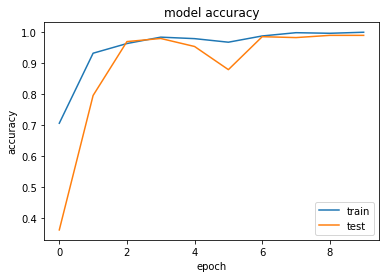

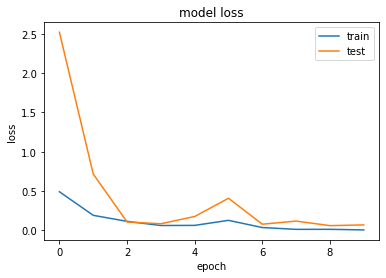

In [46]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()
 

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [47]:
cnnmodel.save("cnnmodel_baseline.h5")

In [ ]:
cnnmodel.predict_classes()

In [57]:
imagename = "/home/kartik/Desktop/coronahack-chest-xraydataset/covid_final_dataset/test/Normal/IM-0001-0001.jpeg"

In [58]:
from keras.preprocessing import image

In [59]:
test_image = image.load_img(imagename, target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis = 0)
result = cnnmodel.predict_classes(test_image)

In [60]:
result

array([1])

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

# Data Augmentation

In [21]:
train_datagen = ImageDataGenerator(
rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=90,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=[0.9, 1.25],
    brightness_range=[0.5, 1.5],
    validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        '/home/kartik/Desktop/coronahack-chest-xraydataset/covid_final_dataset/train',
        target_size=(224,224),
        batch_size=32,
        class_mode='binary',
        subset="training")

validation_generator = train_datagen.flow_from_directory(
        '/home/kartik/Desktop/coronahack-chest-xraydataset/covid_final_dataset/train',
        target_size=(224,224),
        batch_size=32,
        class_mode='binary',
        subset="validation")

cnnmodel=Sequential()

cnnmodel.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', input_shape=(224,224,3)))
cnnmodel.add(MaxPool2D(pool_size=2))
cnnmodel.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
# cnnmodel.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
cnnmodel.add(MaxPool2D(pool_size=2))
cnnmodel.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
cnnmodel.add(MaxPool2D(pool_size=2))
cnnmodel.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
# cnnmodel.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
# cnnmodel.add(BatchNormalization())
cnnmodel.add(Flatten())
cnnmodel.add(Dense(units=64, activation='relu'))
cnnmodel.add(Dense(units=1, activation='sigmoid' , activity_regularizer=l1(0.001)))

cnnmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics = METRICS)

Found 1113 images belonging to 2 classes.
Found 277 images belonging to 2 classes.


In [22]:
cnnmodel.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 224, 224, 128)     1664      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 112, 112, 64)      32832     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 56, 56, 32)        8224      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 32)       

In [23]:
cnn_augment =cnnmodel.fit_generator(
            train_generator,
            steps_per_epoch=len(X_train)/32,
            epochs=20,
            validation_data=validation_generator)

Epoch 1/20
33/32 [==============================] - 57s 2s/step - loss: 0.2135 - tp: 519.0000 - fp: 20.5152 - tn: 0.0000e+00 - fn: 3.0000 - accuracy: 0.9502 - precision: 0.9613 - recall: 0.9879 - auc: 0.4968 - val_loss: 0.1295 - val_tp: 1162.6666 - val_fp: 42.1111 - val_tn: 0.0000e+00 - val_fn: 3.0000 - val_accuracy: 0.9626 - val_precision: 0.9650 - val_recall: 0.9974 - val_auc: 0.5459
Epoch 2/20
33/32 [==============================] - 57s 2s/step - loss: 0.1386 - tp: 1800.0000 - fp: 64.8788 - tn: 0.0000e+00 - fn: 3.0000 - accuracy: 0.9636 - precision: 0.9652 - recall: 0.9983 - auc: 0.6322 - val_loss: 0.1329 - val_tp: 2441.4443 - val_fp: 89.3333 - val_tn: 0.0000e+00 - val_fn: 3.0000 - val_accuracy: 0.9636 - val_precision: 0.9647 - val_recall: 0.9988 - val_auc: 0.6749
Epoch 3/20
33/32 [==============================] - 57s 2s/step - loss: 0.1083 - tp: 3082.2727 - fp: 110.7273 - tn: 0.0000e+00 - fn: 3.0000 - accuracy: 0.9644 - precision: 0.9654 - recall: 0.9990 - auc: 0.7216 - val_loss:

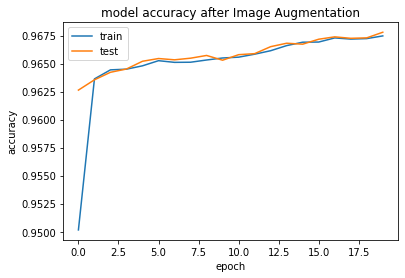

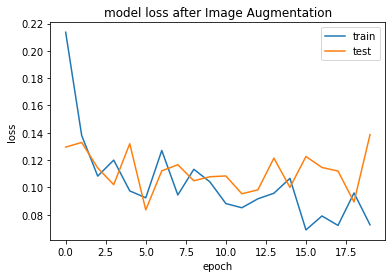

In [24]:
plt.plot(cnn_augment.history['accuracy'])
plt.plot(cnn_augment.history['val_accuracy'])
plt.title('model accuracy after Image Augmentation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()
 

plt.plot(cnn_augment.history['loss'])
plt.plot(cnn_augment.history['val_loss'])
plt.title('model loss after Image Augmentation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [26]:
cnnmodel.save("cnnaugment_baseline.h5")